# Subset an image on a ROI
In this example, we’ll configure pygeodes to use CNES S3, search an item and subset data to process it on a ROI

# Fix a ROI

In [1]:
import geopandas as gpd
import folium
from shapely.geometry import Polygon

pyr_geom = {"type":"Polygon","coordinates":[[[1,42.9],[1.1,42.9],[1.1,42.8],[1,42.8],[1,42.9]]]}
pyr_gpd = gpd.GeoDataFrame(geometry=[Polygon(pyr_geom['coordinates'][0])], crs="EPSG:4326")

f = folium.Figure(width='100%', height=300)
m = folium.Map(location=[43.2, 1.05], zoom_start=8, tiles='OpenStreetMap').add_to(f)

folium.GeoJson(
    pyr_gpd,
    style_function=lambda feature: {
        'color': 'red',
        'weight': 2,
        'fillOpacity': 0
    }
).add_to(m)
m

## Searching products from a specific collection on ROI¶
Now, let's look for products from THEIA_REFLECTANCE_SENTINEL2_L2A collection, that intersect the area of interest for January 2020. To learn more about how to search items,  see [the docs](../user_guide/search_items.rst).

In [2]:
from pygeodes import Geodes
geodes = Geodes()

query = {
    "start_datetime":{"gte":"2020-01-01T00:00:00Z"},
    "end_datetime":{"lte":"2020-01-31T23:59:59Z"}
}
items,dataframe = geodes.search_items(intersects=pyr_geom, query=query, collections=["THEIA_REFLECTANCE_SENTINEL2_L2A"], get_all=True)
item = items[0]

/home/qt/robertm/Documents/pygeodes_user/pygeodes_env_user/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'geodes-portal.cnes.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Found 10 items matching your query


10 item(s) found for query : {'start_datetime': {'gte': '2020-01-01T00:00:00Z'}, 'end_datetime': {'lte': '2020-01-31T23:59:59Z'}}



## Display quicklook

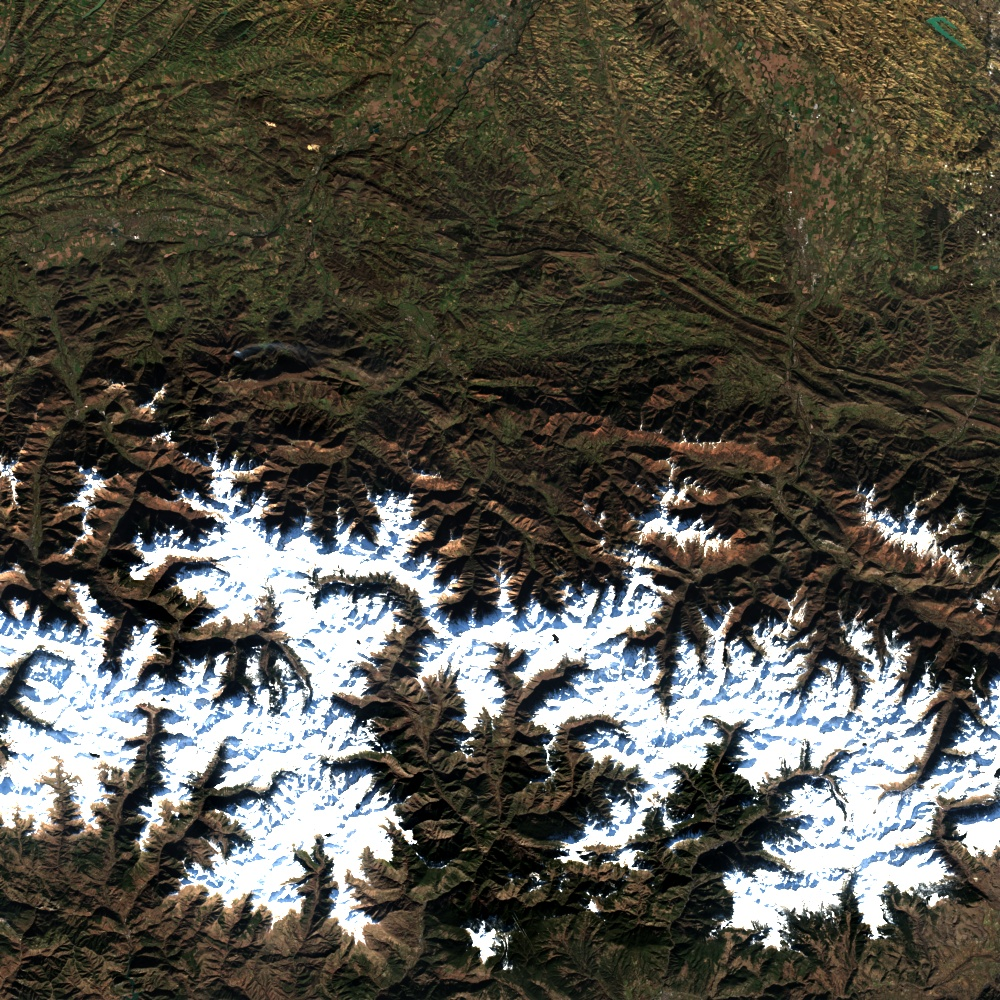

In [3]:
import requests
from IPython.display import Image, display

for file in item.assets:
    if item.assets[file].roles == ['overview'] and item.assets[file].title.split('.')[-1] != 'xml':
        quicklook_url = item.assets[file].href
response = requests.get(quicklook_url)
display(Image(response.content))

# Retrieve the S3 link to the product
GEODES provides a lot of metadata, which is documented [here](https://geodes.cnes.fr/metadonnees-offertes-par-lapi-stac-de-geodes/).. 
Among this metadata, we need the S3 link to the product.

In [4]:

print(f'S3 Access link :\n{item.properties["endpoint_url"]}')

S3 Access link :
https://s3.datalake.cnes.fr/sentinel2-l2a-sprid/T31TCH/2020/01/06/SENTINEL2B_20200106-105907-758_L2A_T31TCH_C/20250425-204503179/SENTINEL2B_20200106-105907-758_L2A_T31TCH_C_V4-0.zip


'endpoint_url' is the link to the zip file. To obtain the link to the bands, we need to reconstruct these complete paths.
Various files named "assets" compose the product. Files pointing to images have the role of "data" to differentiate them from quicklooks or metadata files.

In [5]:
for file in item.assets:
    if item.assets[file].roles == ['data'] and item.assets[file].title.split('.')[-1] != 'xml':
        filename = file
        href = item.assets[file].href
        s3 = item.properties["endpoint_url"]
        urn = item.id
        identifier = item.properties["identifier"]
        
folder = filename.split(".")[0]
url = "zip+s3://"+s3.split("datalake.cnes.fr/")[1]
#Red band
path_to_b4_band=f"{url}/{folder}/{folder}_FRE_B4.tif"
#Green Band
path_to_b3_band=f"{url}/{folder}/{folder}_FRE_B3.tif"
#Blue Band
path_to_b2_band=f"{url}/{folder}/{folder}_FRE_B2.tif"
#NIR Band
path_to_b8_band=f"{url}/{folder}/{folder}_FRE_B8.tif"

## Authentification on the CNES S3

> Please note that the code below can only be used from the CNES SI-S environment. To learn more about how to get CNES S3 credentials, see [the docs](https://hpc.pages.cnes.fr/wiki-hpc-sphinx/datalake-consommateur.html).

In [12]:
import os
from assumerole import assumerole

# public-read-only-OT role
arn = "arn:aws:iam::732885638740:role/public-read-only-OT"
# Set credentials for 1 hour, 60*60s
s3_credentials = assumerole.getCredentials(arn)

Session duration must be between 3600 and 43200. Using default: 3600


## Read the image with RasterIo

In [13]:
%%time
import rasterio

os.environ.update(s3_credentials)
os.environ['AWS_DEFAULT_REGION']="us-east-1"

config_options = {'AWS_S3_ENDPOINT': 's3.datalake.cnes.fr',
                  'AWS_VIRTUAL_HOSTING': 'FALSE',
                  'GDAL_HTTP_UNSAFESSL': 'YES'}


import rioxarray as rxr
import xarray as xr

with rasterio.Env(**config_options):
    xr_da_b2 = rxr.open_rasterio(path_to_b2_band).squeeze() # remove band dimension
    xr_da_b3 = rxr.open_rasterio(path_to_b3_band).squeeze()
    xr_da_b4 = rxr.open_rasterio(path_to_b4_band).squeeze()
    xr_da_b8 = rxr.open_rasterio(path_to_b8_band).squeeze()
    xr_ds = xr.Dataset(data_vars={'blue':xr_da_b2, 'green':xr_da_b3, 'red':xr_da_b4, 'nir': xr_da_b8})

CPU times: user 258 ms, sys: 347 ms, total: 605 ms
Wall time: 3.48 s


## Subset on the ROI

In [14]:
bbox = pyr_gpd.geometry.bounds.iloc[0]

minx = float(bbox['minx'])
miny = float(bbox['miny'])
maxx = float(bbox['maxx'])
maxy = float(bbox['maxy'])

clip_kwargs = dict(minx=minx, miny=miny, maxx=maxx, maxy=maxy, crs="EPSG:4326")
clipped_ds = xr_ds.rio.clip_box(**clip_kwargs)

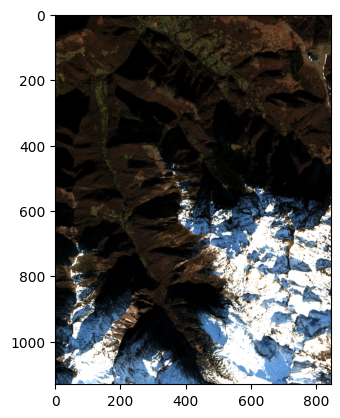

In [15]:
import numpy as np
import matplotlib.pyplot as plt
 
with rasterio.Env(**config_options):
    red_min = clipped_ds.red.quantile(0.10)
    red_max = clipped_ds.red.quantile(0.90)
    green_min = clipped_ds.green.quantile(0.10)
    green_max = clipped_ds.green.quantile(0.90)
    blue_min = clipped_ds.blue.quantile(0.10)
    blue_max = clipped_ds.blue.quantile(0.90)
    clipped_rgb = np.clip(np.stack([(clipped_ds.red - red_min)/(red_max-red_min), (clipped_ds.green - green_min)/(green_max-green_min), (clipped_ds.blue - blue_min)/(blue_max-blue_min)]), 0, 1)
plt.imshow(np.moveaxis(clipped_rgb, 0, -1))